In [3]:
import itertools
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import load_dotenv
from yolov5.utils.plots import save_one_box

from utils.shortcut import get_fake_result
from utils.yolo import crop_by_xyxy, crop_by_two_tooth

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline



In [4]:
model_path = Path(os.getenv('YOLO_MODEL_DIR')) / '8-bound.pt'
model = torch.hub.load(r'..\YOLO', 'custom', path=model_path, source='local') if model_path.is_file() else None

data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'

data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

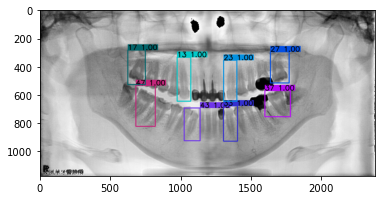

In [5]:
image_names = list(data_dir.glob('00008026.jpg'))

image_name = image_names[0]
filename = image_name.stem

if model:
    results = model(image_name)
    detected_results = model(image_name)
else:
    results = get_fake_result(image_name)
    detected_results = get_fake_result(image_name)

rendered_results = results.render()

# results.save('temp.png')
#
# from PIL import Image
# im = Image.fromarray(rendered_results[0])
# im.save("your_file.jpeg")

plt.imshow(1 - rendered_results[0])
plt.show()


In [6]:
flag_dict = {
    'upper': [
        '17', '13', '23', '27'
    ],
    'lower': [
        '47', '43', '33', '37'
    ]
}

tooth_number_flag_dict = {
    '1': ('upper', 'left'),
    '2': ('upper', 'right'),
    '3': ('lower', 'right'),
    '4': ('lower', 'left'),
}

tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}


In [7]:
images = {}
split_teeth = {}

file_name = detected_results.files[0][:-4]
bounds = detected_results.xyxy[0]
img = detected_results.imgs[0]

images[file_name] = []
split_teeth[file_name] = {}


In [8]:
tooth_bounds = []
for j in range(len(bounds)):
    x1, y1, x2, y2, _, cls = bounds[j]
    x1, x2 = min(x1, x2), max(x1, x2)
    y1, y2 = min(y1, y2), max(y1, y2)
    xyxy = torch.vstack([x1, y1, x2, y2])

    cls = int(cls.item())
    name = detected_results.names[cls]
    tooth_bounds.append({'xyxy': xyxy, 'name': name})

tooth_bounds


[{'xyxy': tensor([[ 973.30303],
          [ 334.57576],
          [1070.27273],
          [ 645.18182]], dtype=torch.float64),
  'name': '13'},
 {'xyxy': tensor([[1303.60606],
          [ 355.78788],
          [1397.54545],
          [ 645.18182]], dtype=torch.float64),
  'name': '23'},
 {'xyxy': tensor([[1302.09091],
          [ 678.51515],
          [1402.09091],
          [ 928.51515]], dtype=torch.float64),
  'name': '33'},
 {'xyxy': tensor([[1023.30303],
          [ 693.66667],
          [1136.93939],
          [ 925.48485]], dtype=torch.float64),
  'name': '43'},
 {'xyxy': tensor([[623.30303],
          [283.06061],
          [747.54545],
          [528.51515]], dtype=torch.float64),
  'name': '17'},
 {'xyxy': tensor([[1635.42424],
          [ 295.18182],
          [1768.75758],
          [ 516.39394]], dtype=torch.float64),
  'name': '27'},
 {'xyxy': tensor([[1596.03030],
          [ 570.93939],
          [1777.84848],
          [ 755.78788]], dtype=torch.float64),
  'name': '37

In [9]:
teeth_dict = {}
for j in range(len(tooth_bounds)):
    xyxy = tooth_bounds[j]['xyxy']
    name = tooth_bounds[j]['name']

    teeth_dict[name] = xyxy

    crop_image = crop_by_xyxy(img, xyxy.int())
    split_teeth[file_name][name] = {'xyxy': xyxy, 'crop_image': crop_image}

split_teeth


{'00008026': {'13': {'xyxy': tensor([[ 973.30303],
           [ 334.57576],
           [1070.27273],
           [ 645.18182]], dtype=torch.float64),
   'crop_image': array([[[58, 58, 58],
           [58, 58, 58],
           [57, 57, 57],
           ...,
           [49, 49, 49],
           [48, 48, 48],
           [49, 49, 49]],
   
          [[60, 60, 60],
           [60, 60, 60],
           [59, 59, 59],
           ...,
           [48, 48, 48],
           [46, 46, 46],
           [46, 46, 46]],
   
          [[57, 57, 57],
           [59, 59, 59],
           [60, 60, 60],
           ...,
           [57, 57, 57],
           [53, 53, 53],
           [51, 51, 51]],
   
          ...,
   
          [[60, 60, 60],
           [58, 58, 58],
           [58, 58, 58],
           ...,
           [30, 30, 30],
           [30, 30, 30],
           [30, 30, 30]],
   
          [[58, 58, 58],
           [57, 57, 57],
           [57, 57, 57],
           ...,
           [30, 30, 30],
           [30, 30

In [10]:
a = itertools.product(('upper', 'lower'), range(len(tooth_bounds)))

tooth_detected_tuples = []
for flag in ('upper', 'lower'):
    flag_list = flag_dict[flag]
    teeth_detected_flag = [f in teeth_dict for f in flag_list]
    tooth_detected_tuples += [
        (flag_list[j], flag_list[j + 1], j, flag)
        for j in range(len(flag_list) - 1)
        if teeth_detected_flag[j] and teeth_detected_flag[j + 1]
    ]

tooth_detected_tuples


[('17', '13', 0, 'upper'),
 ('13', '23', 1, 'upper'),
 ('23', '27', 2, 'upper'),
 ('47', '43', 0, 'lower'),
 ('43', '33', 1, 'lower'),
 ('33', '37', 2, 'lower')]

In [11]:
for left_tooth_number, right_tooth_number, number, flag in tooth_detected_tuples:
    left_tooth = teeth_dict[left_tooth_number]
    right_tooth = teeth_dict[right_tooth_number]

    margin = 50
    x_indices = [0, 2]
    y_indices = [1, 3]
    x_items = torch.Tensor([*left_tooth[x_indices], *right_tooth[x_indices]])
    y_items = torch.Tensor([*left_tooth[y_indices], *right_tooth[y_indices]])

    padding = [torch.sum(x_items[[0, 1]]) / 2, torch.sum(x_items[[2, 3]]) / 2]
    x_items_padded = [torch.sum(x_items[[0, 1]]) / 2, torch.sum(x_items[[2, 3]]) / 2]

    crop = torch.Tensor([
        x_items_padded[0],
        torch.min(y_items) - margin,
        x_items_padded[1],
        torch.max(y_items) + margin,
    ])
    region = crop.int()
    region = crop_by_two_tooth(left_tooth, right_tooth)
    print(region)

    tooth_position = tooth_position_dict[number]

    save_filename = f'{flag}-{number}-{file_name}'
    save_file = Path(f'./crops/{save_filename}.jpg')

    im = save_one_box(region, img, save=False, file=save_file)
    # print(f'First ROI process: {save_filename} done.')

    image_data = {
        'flag': flag,
        'tooth_position': tooth_position,
        'org_file_name': file_name,
        'offset': np.array([region[0], region[1]]),
        'image': im,
        'xyxy': region,
    }

    images[file_name].append(image_data)

images


tensor([ 673,  233, 1020,  695], dtype=torch.int32)
tensor([1023,  284, 1347,  695], dtype=torch.int32)
tensor([1353,  245, 1718,  695], dtype=torch.int32)
tensor([ 730,  484, 1086,  975], dtype=torch.int32)
tensor([1073,  628, 1352,  978], dtype=torch.int32)
tensor([1352,  520, 1727,  978], dtype=torch.int32)


/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/yolov5/utils/plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


{'00008026': [{'flag': 'upper',
   'tooth_position': 'left',
   'org_file_name': '00008026',
   'offset': array([673, 233], dtype=int32),
   'image': array([[[ 55,  55,  55],
           [ 53,  53,  53],
           [ 52,  52,  52],
           ...,
           [ 64,  64,  64],
           [ 64,  64,  64],
           [ 65,  65,  65]],
   
          [[ 55,  55,  55],
           [ 52,  52,  52],
           [ 50,  50,  50],
           ...,
           [ 65,  65,  65],
           [ 65,  65,  65],
           [ 65,  65,  65]],
   
          [[ 56,  56,  56],
           [ 54,  54,  54],
           [ 51,  51,  51],
           ...,
           [ 71,  71,  71],
           [ 70,  70,  70],
           [ 69,  69,  69]],
   
          ...,
   
          [[133, 133, 133],
           [134, 134, 134],
           [128, 128, 128],
           ...,
           [104, 104, 104],
           [107, 107, 107],
           [108, 108, 108]],
   
          [[137, 137, 137],
           [138, 138, 138],
           [132, 132, 

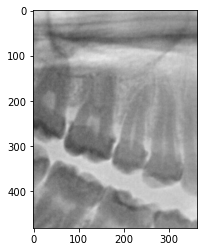

In [12]:
images[image_name.stem][0].keys()
im = images[image_name.stem][0]['image']

plt.imshow(1 - im)
plt.show()


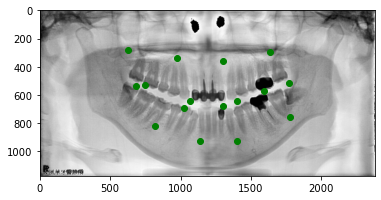

In [13]:
im = cv.imread(image_name)
plt.imshow(1 - im)

for i in teeth_dict.values():
    plt.plot(*i[:2], color='green', marker='o')
    plt.plot(*i[2:], color='green', marker='o')

plt.show()

